# <div align="center">**Doug Delaney**</div>
## <div align="center">*Applied Data Science Capstone - Segmenting and Clustering Neighborhoods in Toronto*</div>
### <div align="center">Coursera_Capstone</div>

# Prerequisites: install and load modules

## NOTATION: This notebook is divided into 3 sections by task.  
- Task 1 = Web scraping and Cleaning
- Task 2 = Gather location data
- Task 3 = Mapping, Exploring, and Clustering

REVIEW INSTRUCTIONS

Use CTRL + F to find "Task 1"  This will show you the start and end of Task 1.  Repeat for "Task 2" and "Task 3"

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import random # library for random number generation

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
from IPython.display import display_html

import json # library to handle JSON files

# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
# !pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# !pip install beautifulsoup4
# !pip install lxml
from bs4 import BeautifulSoup
import lxml

# !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
# !pip install folium
import folium # map rendering library

import fnmatch # wildcard match
import re # Regular Expressions

print('Libraries imported.')

Libraries imported.


In [2]:
# functions to use left, right and mid, as I could in VB (and vbscript, VBA, etc.).  I think it is easier to read than slicing
def left(str, amount):
    return str[:amount]

def right(str, amount):
    return str[-amount:]

def mid(str, offset, amount):
    return str[offset-1:offset+amount-1]

# Task 1 - Web scraping and Cleaning

---

## Scraping the Wikipedia page for postal codes of Canada. Postal codes beginning with M are located within the city of Toronto

In [3]:
# Task 1 - Start code

# from IPython.core.debugger import set_trace

url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
raw_data = requests.get(url).text
# raw_data_decode = raw_data.content.decode()
# raw_json_data = requests.get(url).json()
# raw_json_data
soup=BeautifulSoup(raw_data,'lxml')
print("soup type: ")
print(type(soup))
soup
table = soup.find_all("table")[0]

table_paras = table.tbody.find_all("p")

content=''
p_code=''
burough=''
neighborhood=''
row=''
temp=''
temp2=''
bu=''
nh=''
bu2=''
nh1=''
nh2=''
t1=''
t2=''
t3=''
t4=''

column_names = ['PostalCode','Borough','Neighborhood']    # FOR LATER ['Borough', 'Neighborhood', 'Latitude', 'Longitude']
df=pd.DataFrame(columns=column_names,index=None)

for tag in table.tbody.find_all('p'):
    content += tag.text
    
rows = content.splitlines()

for row in rows:
    bu=''
    nh=''
    bu2=''
    nh1=''
    nh2=''
    t1=''
    t2=''
    t3=''
    t4=''
    lreturn=''
    rreturn=''
    temp=''
    temp_new=''
    gotMatch=False


    row = row.rstrip()
    row = row.strip('\n')
    # get the first 3 characters
    p_code = left(row,3)
    # get the rest of the line
    temp2=mid(row, 4, len(row))
    # strip the \n (if in temp2)
    if '\n' in temp2:
        temp=temp2.strip('\n')
    else:
        temp=temp2
        
    # FIND Toronto strings that do not have Toronto( and instead have TorontoE (for example)
    found = any(re.search(regex_str, temp) for regex_str in ["Etobicoke\w", "Toronto\w", "Mississauga\w"])
    if found:
        gotMatch=False
        regexList = ["Etobicoke\w", "Toronto\w", "Mississauga\w"]
        for regex in regexList:
            s = re.search(regex,temp)
            if s:
                gotMatch = True
                rreturn=s
                break

    if gotMatch:
        substr=rreturn

        if "(" in temp:
            temp_new = temp.replace('(', ' - ')

        substr = mid(temp_new,rreturn.span()[0]+1,rreturn.span()[1]-rreturn.span()[0])
        s1 = mid(substr,1,len(substr)-1)
        s2 = right(substr, 1)
        newstr = s1 + "(" + s2
        temp_new = temp_new.replace(substr,newstr,1)
        if newstr == 'Etobicoke(N':
            temp_new = temp_new.replace("Etobicoke(Northwest - ", "Etobicoke - Northwest (")
        temp=temp_new

    if '(' not in temp:
        bu = temp
        # DON'T ADD to DF if values are 'Not assigned' .  I see no need to duplicate the burough into neighborhood for Not Assigned
        # df=df.append({'Postal Code':p_code, 'Burough':bu, 'Neighborhoods':bu}, ignore_index=True)
    elif temp.count('(') >= 1 and temp.count('(') < 2:
        # Handle the other lines that include "("
        t1,t2 = temp.split('(',2)
    
        bu=t1
        lreturn = fnmatch.filter(t2,')?')
        if not lreturn:
            nh1=t2.replace(')',' - ')
            nh = nh1
        else:
            nh1=t2.replace(')','')
            nh = nh1
            
        str2=right(nh, 3)
        if str2 == ' - ': 
            nh = nh.replace(' - ','')
        if 'East YorkEast Toronto' in bu:
            bu = bu.replace('East YorkEast Toronto', 'East York - East Toronto')
        if ' / ' in nh: 
            nh = nh.replace(' / ',', ')              
        df=df.append({'PostalCode':p_code, 'Borough':bu, 'Neighborhood':nh}, ignore_index=True)
    elif temp.count('(') >= 1 and temp.count('(') <= 2:  
        t1,t2,t3 = temp.split('(',3)
        bu=t1
        lreturn = fnmatch.filter(t2,')?')
        if not lreturn:
            nh1=t2.replace(')',' - ')
            nh2 = t3.replace(')','')
            nh = nh1 + " / " + nh2
        else:
            nh1=t2.replace(')','')
            nh2 = t3.replace(')','')
            nh = nh1 + " / " + nh2
        
        str2=right(nh, 3)
        if str2 == ' - ': 
            nh = nh.replace(' - ','')
        if 'East YorkEast Toronto' in bu:
            bu = bu.replace('East YorkEast Toronto', 'East York - East Toronto')
        if ' / ' in nh: 
            nh = nh.replace(' / ',', ')            
        df=df.append({'PostalCode':p_code, 'Borough':bu, 'Neighborhood':nh}, ignore_index=True)
    else:
        bu,nh = temp.split('(',2)
#             burough = bu
#             neighborhoods = nh
        nh = nh.strip(')')
    
        str2=right(nh, 3)
        # I didn't spend the time and instead duplicated this code 3 times (2 above).  I am sure there is a better way to do all this - but I am working towards a function that handles all kinds of exceptions to the rule.
        if str2 == ' - ': 
            nh = nh.replace(' - ','')
        if 'East YorkEast Toronto' in bu:
            bu = bu.replace('East YorkEast Toronto', 'East York - East Toronto')
        if ' / ' in nh: 
            nh = nh.replace(' / ',', ')              
        df=df.append({'PostalCode':p_code, 'Borough':bu, 'Neighborhood':nh}, ignore_index=True)

df



soup type: 
<class 'bs4.BeautifulSoup'>


,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills - North
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [4]:
df.shape

# Task 1 - End code

(103, 3)

# END of Task 1

---

# Task 2 - Gather location data

### Method 1 - use pgeocode
---

In [5]:
# Task 2 - Start of code.


# Method 1 - use pgeocode
# !pip install pgeocode
import pgeocode

postal_code = df['PostalCode'].tolist()

geo = pgeocode.Nominatim('ca')
geo = pgeocode.Nominatim('ca')
location = geo.query_postal_code(postal_code)
latitude = location.latitude
longitude = location.longitude

In [6]:
dfll = pd.DataFrame([latitude,longitude]).transpose().astype(float)
dfll.rename(columns={'latitude':'Latitude','longitude':'Longitude'}, inplace=True)
# dfll.dropna(inplace=True)
# dfll = dfll.reset_index(drop=True)  # SAVED for later, after merge
print(dfll.shape)
dfll

(103, 2)


,Latitude,Longitude
0,43.7545,-79.3300
1,43.7276,-79.3148
2,43.6555,-79.3626
3,43.7223,-79.4504
4,43.6641,-79.3889
5,43.6662,-79.5282
6,43.8113,-79.1930
7,43.7450,-79.3590
8,43.7063,-79.3094
9,43.6572,-79.3783


<!--# @hidden_cell-->
# DO NOT RUN THIS CELL
# Method 2 - use geocoder
# recommended method

# I had trouble with this method... it ran and ran, timed out... never got actual results.

# !pip install geocoder
<!--
        import geocoder # import geocoder

        # initialize your variable to None
        lat_lng_coords = None

        # loop until you get the coordinates
        while(lat_lng_coords is None):
            g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
            lat_lng_coords = g.latlng

        g_latitude = lat_lng_coords[0]
        g_longitude = lat_lng_coords[1]
-->

<!--
# DO NOT RUN THIS CELL
g_dfll = pd.DataFrame([g_latitude,g_longitude]).transpose().astype(float)
g_dfll.rename(columns={'g_latitude':'Latitude','g_longitude':'Longitude'}, inplace=True)
print(g_dfll.shape)
g_dfll
-->

<!--# @hidden_cell-->
# DO NOT RUN THIS CELL
# Method 3 - use the csv file
<!--
c_dfll= pd.read_csv("http://cocl.us/Geospatial_data")
c_dfll.rename(columns={'Postal Code':'PostalCode'}, inplace=True)
c_dfll.set_index("PostalCode")
c_df = df.copy()
c_df.set_index("PostalCode")
c_d_df=pd.merge(c_df, c_dfll)
c_d_df.head()
-->
I did not use method 2 or 3, I used method 1

In [9]:
# using method 1 location data
new_df = pd.concat([df, dfll], axis=1)
# drop the NaN value
new_df.dropna(inplace=True)
new_df = new_df.reset_index(drop=True)
print(new_df.shape)
new_df

(102, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.7545,-79.3300
1,M4A,North York,Victoria Village,43.7276,-79.3148
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.7223,-79.4504
4,M7A,Queen's Park,Ontario Provincial Government,43.6641,-79.3889
5,M9A,Etobicoke,Islington Avenue,43.6662,-79.5282
6,M1B,Scarborough,"Malvern, Rouge",43.8113,-79.1930
7,M3B,North York,Don Mills - North,43.7450,-79.3590
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.7063,-79.3094
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.6572,-79.3783


# END of Task 2

---

# Task 3 - Mapping, Exploring, and Clustering

In [39]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(new_df['Borough'].unique()),
        new_df.shape[0]
    )
)

The dataframe has 12 boroughs and 102 neighborhoods.


In [10]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="toronto_explorer")
T_location = geolocator.geocode(address)
T_latitude = T_location.latitude
T_longitude = T_location.longitude
print('The geograpical coordinate of Toronto, ON are {}, {}.'.format(T_latitude, T_longitude))

The geograpical coordinate of Toronto, ON are 43.6534817, -79.3839347.


In [11]:
# create map of Toronto, ON using latitude and longitude values
map_toronto = folium.Map(location=[T_latitude, T_longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(new_df['Latitude'], new_df['Longitude'], new_df['Borough'], new_df['Neighborhood']):
    label = '{}, {}'.format('Borough: ' + borough, 'Neighborhood(s): ' + neighborhood)  # MY NOTES: That is how I should have done it in the last lab...
    # increase width for nicer display
    label = folium.Popup(label, parse_html=True, max_width=2650)
    tip = folium.Tooltip(borough) # add a hover tooltip
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        tooltip=tip,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

# Inserted ScreenShot - GitHub may not display the actual map...
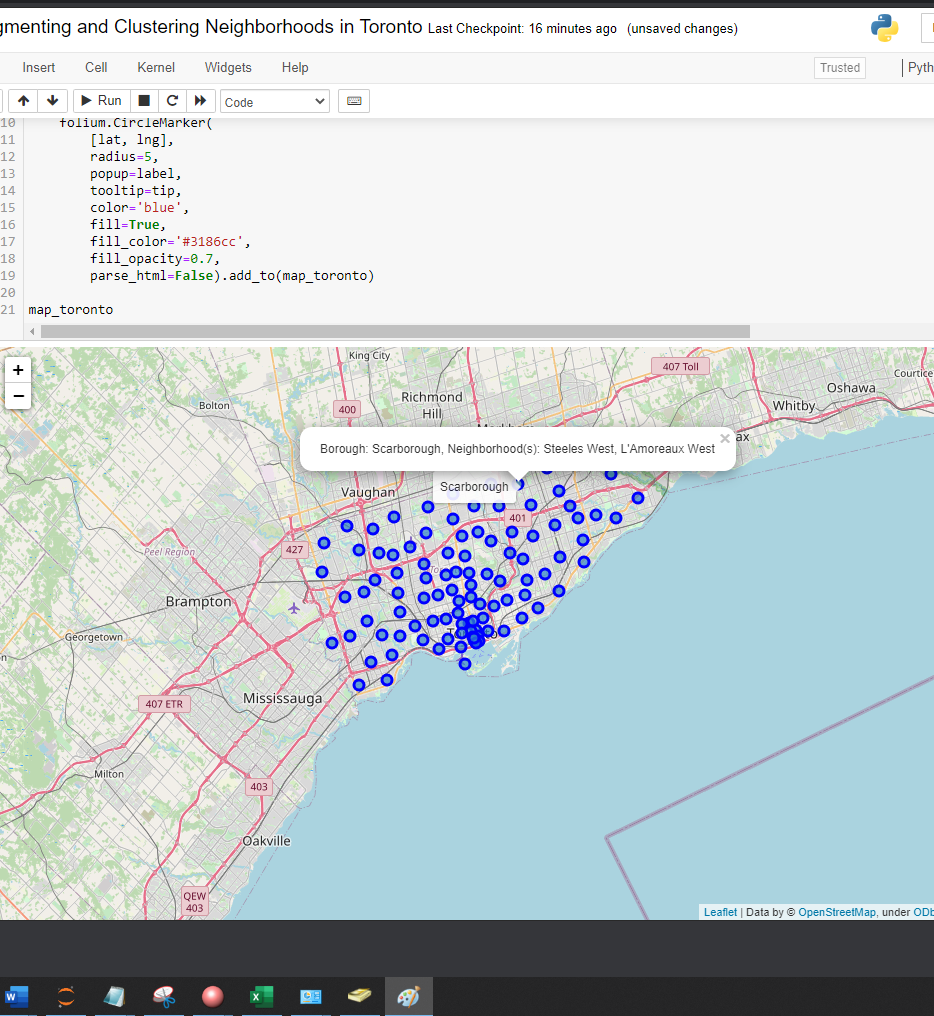

## Exploring (Foursquare)

### Collecting all borough "points" for future use


In [51]:
# End up not needing this...
new_points = new_df.loc[:,'Latitude':'Longitude']
new_points

,Latitude,Longitude
0,43.7545,-79.3300
1,43.7276,-79.3148
2,43.6555,-79.3626
3,43.7223,-79.4504
4,43.6641,-79.3889
5,43.6662,-79.5282
6,43.8113,-79.1930
7,43.7450,-79.3590
8,43.7063,-79.3094
9,43.6572,-79.3783


In [180]:
### Foursquare config
fsq_IDs = pd.read_csv('c:\keep\Foursquare-IDs.csv')
# breakpoint()
CID = fsq_IDs.loc[fsq_IDs['ID'] == 'CLIENT_ID']
CIDx = fsq_IDs.index[fsq_IDs['ID'] == 'CLIENT_ID'].astype('int64')[0]
CSEC = fsq_IDs.loc[fsq_IDs['ID'] == 'CLIENT_SECRET']
CSECx = fsq_IDs.index[fsq_IDs['ID'] == 'CLIENT_SECRET'].astype('int64')[0]
CAT = fsq_IDs.loc[fsq_IDs['ID'] == 'ACCESS_TOKEN']
CATx = fsq_IDs.index[fsq_IDs['ID'] == 'ACCESS_TOKEN'].astype('int64')[0]
# print(ID + "\n" + SEC + "\n" + AT)
# print("ID: " + ID)
# print(ID['ID'])
# print(ID['Value'])
C_ID=CID['Value'][CIDx]
C_SEC=CSEC['Value'][CSECx]
C_AT=CAT['Value'][CATx]
# print("CLIENT_ID: " + C_ID +"\nCLIENT_SECRET: " + C_SEC + "\nACCESS_TOKEN: " + C_AT)
# print(C_ID)
# print(C_SEC)
# print(C_AT)

In [181]:

CLIENT_ID = C_ID # your Foursquare ID
CLIENT_SECRET = C_SEC # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
#LIMIT = 30
# print('Your credentails:')
# print('CLIENT_ID: ' + CLIENT_ID)
# print('CLIENT_SECRET:' + CLIENT_SECRET)

#### Explore Foursquare data for venues within 500 meters of a Neighborhood(s).  Why not ask for the Neighborhood... 
#### ... like an app may, and create a temp_df to use to explore venues.

In [271]:
my_nh = input("Which Neighborhood would you like to explore venues: ")
my_dist = input("How close should the venues be?  in meters: ")
print(my_nh)
print('Distance is venues within {} meters, ({:.2f} feet).'.format(int(my_dist),int(my_dist)/3.28084))

Which Neighborhood would you like to explore venues: Don Mills
How close should the venues be?  in meters: 1000
Don Mills
Distance is venues within 1000 meters, (304.80 feet).


In [220]:
# temp_df = new_df['Neighborhood'].
# qry = "'" + 'Neighborhood.str.contains('+ chr(34) + my_nh + chr(34) + ')' + "'"
# print(qry)
print(my_nh)
# my_nh = chr(34) + my_nh + chr(34)
print(my_nh)
# temp_df = new_df.query(qry,inplace=False )
# temp_df = new_df.query(str('Neighborhood.str.contains("Don Mills")'), inplace=False)
# df[df['A'].str.contains("Hello|Britain")]
# Temporary Neighborhood df
temp_nh_df=new_df[new_df['Neighborhood'].str.contains(my_nh)]
temp_nh_df

Don Mills
Don Mills


,PostalCode,Borough,Neighborhood,Latitude,Longitude
7,M3B,North York,Don Mills - North,43.7450,-79.3590
13,M3C,North York,"Don Mills - South, Flemingdon Park",43.7334,-79.3329


In [225]:
# count the rows
index = temp_nh_df.index
number_of_rows = len(index)
print(number_of_rows)
# temp_df.index.count()
print(len(temp_nh_df))
t_r_max = len(temp_nh_df)

2
2


In [315]:
for index, row in temp_nh_df.iterrows():
    print(index)
# for i in temp_nh_df[:1]:
#     print(i)
temp_nh_df

7
13


,PostalCode,Borough,Neighborhood,Latitude,Longitude
7,M3B,North York,Don Mills - North,43.7450,-79.3590
13,M3C,North York,"Don Mills - South, Flemingdon Park",43.7334,-79.3329


In [313]:
temp_nh_df.dtypes

PostalCode       object
Borough          object
Neighborhood     object
Latitude        float64
Longitude       float64
dtype: object

In [319]:
# re-create map of user input Neighborhood string and distance using latitude and longitude values
map_temp_nh = folium.Map(location=[T_latitude, T_longitude], zoom_start=10)

# add markers to map
for lat, lng, label in zip(temp_nh_df['Latitude'],
                           temp_nh_df['Longitude'],
                           temp_nh_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_temp_nh)  
    
map_temp_nh

#### Inserted snapshot in case GitHub won't display the cell above...

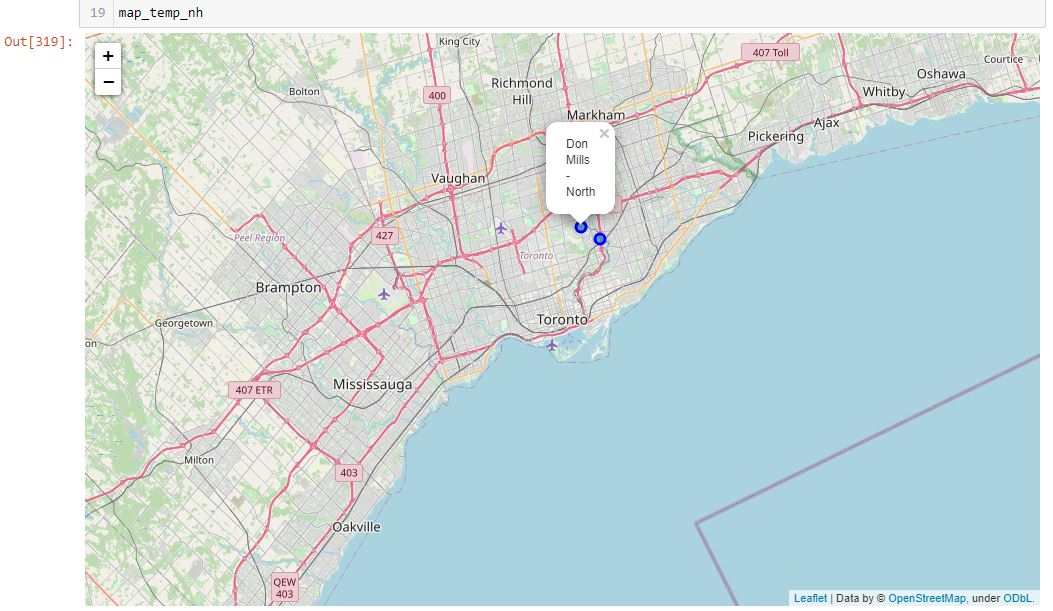

In [272]:
# extract the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [273]:
# get nearby venues
def getNearbyVenues(names, latitudes, longitudes, radius=my_dist, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [274]:
# Create temp_nh_venues dataframe for the Neighborhood(s) returned
for index, row in temp_nh_df.iterrows():
    temp_nh_venues = getNearbyVenues(names=temp_nh_df['Neighborhood'],
                                       latitudes=temp_nh_df['Latitude'],
                                       longitudes=temp_nh_df['Longitude']
                                      )

Don Mills - North
Don Mills - South, Flemingdon Park
Don Mills - North
Don Mills - South, Flemingdon Park


In [275]:
print(temp_nh_venues.shape)
temp_nh_venues    # .head()

(55, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Don Mills - North,43.7450,-79.3590,Big Smoke Burger,43.752836,-79.358998,Burger Joint
1,Don Mills - North,43.7450,-79.3590,Booster Juice,43.753767,-79.359005,Juice Bar
2,Don Mills - North,43.7450,-79.3590,RBC Royal Bank,43.753041,-79.358241,Bank
3,Don Mills - North,43.7450,-79.3590,Second Cup,43.753805,-79.358064,Coffee Shop
4,Don Mills - North,43.7450,-79.3590,Petro-Canada,43.753062,-79.359937,Gas Station
5,Don Mills - North,43.7450,-79.3590,Windfields Restaurant,43.753310,-79.358837,Diner
6,Don Mills - North,43.7450,-79.3590,Elite Basketball Camps,43.748790,-79.354228,Athletics & Sports
7,Don Mills - North,43.7450,-79.3590,Swiss Chalet,43.753119,-79.357777,Restaurant
8,Don Mills - North,43.7450,-79.3590,Country Style,43.752962,-79.359781,Coffee Shop
9,Don Mills - North,43.7450,-79.3590,McDonald's,43.753642,-79.358954,Fast Food Restaurant


How many venues were returned for each neighborhood

In [276]:
temp_nh_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Don Mills - North,13,13,13,13,13,13
"Don Mills - South, Flemingdon Park",42,42,42,42,42,42


### Analyze each neighborhood...

In [279]:
# one hot encoding
temp_nh_onehot = pd.get_dummies(temp_nh_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
temp_nh_onehot['Neighborhood'] = temp_nh_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [temp_nh_onehot.columns[-1]] + list(temp_nh_onehot.columns[:-1])
temp_nh_onehot = temp_nh_onehot[fixed_columns]

temp_nh_onehot  # .head()

,Neighborhood,Accessories Store,Art Gallery,Athletics & Sports,Bakery,Bank,Beer Store,Burger Joint,Bus Line,Café,Coffee Shop,Diner,Fast Food Restaurant,Gas Station,Gourmet Shop,Gym,Gym / Fitness Center,History Museum,Hockey Arena,Ice Cream Shop,Juice Bar,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Park,Pizza Place,Restaurant,Salon / Barbershop,Sandwich Place,Shopping Mall,Soccer Field,Supermarket,Sushi Restaurant,Trail,Volleyball Court
0,Don Mills - North,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Don Mills - North,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Don Mills - North,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Don Mills - North,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Don Mills - North,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Don Mills - North,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Don Mills - North,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Don Mills - North,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
8,Don Mills - North,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Don Mills - North,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [280]:
temp_nh_onehot.shape

(55, 35)

Group rows by neighborhood and analyze categories

In [282]:
temp_nh_grouped = temp_nh_onehot.groupby('Neighborhood').mean().reset_index()
temp_nh_grouped

,Neighborhood,Accessories Store,Art Gallery,Athletics & Sports,Bakery,Bank,Beer Store,Burger Joint,Bus Line,Café,Coffee Shop,Diner,Fast Food Restaurant,Gas Station,Gourmet Shop,Gym,Gym / Fitness Center,History Museum,Hockey Arena,Ice Cream Shop,Juice Bar,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Park,Pizza Place,Restaurant,Salon / Barbershop,Sandwich Place,Shopping Mall,Soccer Field,Supermarket,Sushi Restaurant,Trail,Volleyball Court
0,Don Mills - North,0.00000,0.00000,0.076923,0.00000,0.076923,0.00000,0.076923,0.00000,0.00000,0.153846,0.076923,0.076923,0.076923,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.076923,0.00000,0.000000,0.00000,0.076923,0.000000,0.076923,0.000000,0.076923,0.000000,0.076923,0.00000,0.00000,0.00000,0.00000
1,"Don Mills - South, Flemingdon Park",0.02381,0.02381,0.000000,0.02381,0.023810,0.02381,0.023810,0.02381,0.02381,0.095238,0.000000,0.000000,0.000000,0.02381,0.071429,0.02381,0.02381,0.02381,0.02381,0.000000,0.02381,0.047619,0.02381,0.047619,0.047619,0.119048,0.047619,0.000000,0.047619,0.023810,0.02381,0.02381,0.02381,0.02381


In [284]:
temp_nh_grouped.shape

(2, 35)

And the top 5 per neighborhood are...

In [287]:
num_top_venues = 5

for hood in temp_nh_grouped['Neighborhood']:
    print("["+hood+"]")
    temp = temp_nh_grouped[temp_nh_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

[Don Mills - North]
                venue  freq
0         Coffee Shop  0.15
1               Diner  0.08
2      Sandwich Place  0.08
3  Athletics & Sports  0.08
4           Juice Bar  0.08


[Don Mills - South, Flemingdon Park]
                       venue  freq
0                 Restaurant  0.12
1                Coffee Shop  0.10
2                        Gym  0.07
3                Pizza Place  0.05
4  Middle Eastern Restaurant  0.05




Put into a dataframe

In [288]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [302]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = temp_nh_grouped['Neighborhood']

for ind in np.arange(temp_nh_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(temp_nh_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Don Mills - North,Coffee Shop,Gas Station,Fast Food Restaurant,Athletics & Sports,Soccer Field,Diner,Sandwich Place,Bank,Restaurant,Park
1,"Don Mills - South, Flemingdon Park",Restaurant,Coffee Shop,Gym,Salon / Barbershop,Middle Eastern Restaurant,Park,Pizza Place,Shopping Mall,Beer Store,Gym / Fitness Center


### Cluster Neighborhoods

In [305]:
# set number of clusters
kclusters = len(temp_nh_grouped)

temp_nh_grouped_clustering = temp_nh_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(temp_nh_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print ("cluster labels are :", kmeans.labels_[0:len(temp_nh_grouped)])
temp_nh_grouped_clustering.head()

cluster labels are : [0 1]


,Accessories Store,Art Gallery,Athletics & Sports,Bakery,Bank,Beer Store,Burger Joint,Bus Line,Café,Coffee Shop,Diner,Fast Food Restaurant,Gas Station,Gourmet Shop,Gym,Gym / Fitness Center,History Museum,Hockey Arena,Ice Cream Shop,Juice Bar,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Park,Pizza Place,Restaurant,Salon / Barbershop,Sandwich Place,Shopping Mall,Soccer Field,Supermarket,Sushi Restaurant,Trail,Volleyball Court
0,0.00000,0.00000,0.076923,0.00000,0.076923,0.00000,0.076923,0.00000,0.00000,0.153846,0.076923,0.076923,0.076923,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.076923,0.00000,0.000000,0.00000,0.076923,0.000000,0.076923,0.000000,0.076923,0.000000,0.076923,0.00000,0.00000,0.00000,0.00000
1,0.02381,0.02381,0.000000,0.02381,0.023810,0.02381,0.023810,0.02381,0.02381,0.095238,0.000000,0.000000,0.000000,0.02381,0.071429,0.02381,0.02381,0.02381,0.02381,0.000000,0.02381,0.047619,0.02381,0.047619,0.047619,0.119048,0.047619,0.000000,0.047619,0.023810,0.02381,0.02381,0.02381,0.02381


Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [309]:
new_df

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.7545,-79.3300
1,M4A,North York,Victoria Village,43.7276,-79.3148
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.7223,-79.4504
4,M7A,Queen's Park,Ontario Provincial Government,43.6641,-79.3889
5,M9A,Etobicoke,Islington Avenue,43.6662,-79.5282
6,M1B,Scarborough,"Malvern, Rouge",43.8113,-79.1930
7,M3B,North York,Don Mills - North,43.7450,-79.3590
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.7063,-79.3094
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.6572,-79.3783


In [321]:
# add clustering labels
# neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

temp_nh_merged = temp_nh_df

# merge temp_nh_grouped with temp_nh_data to add latitude/longitude for each neighborhood
temp_nh_merged = temp_nh_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

temp_nh_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,M3B,North York,Don Mills - North,43.7450,-79.3590,0,Coffee Shop,Gas Station,Fast Food Restaurant,Athletics & Sports,Soccer Field,Diner,Sandwich Place,Bank,Restaurant,Park
13,M3C,North York,"Don Mills - South, Flemingdon Park",43.7334,-79.3329,1,Restaurant,Coffee Shop,Gym,Salon / Barbershop,Middle Eastern Restaurant,Park,Pizza Place,Shopping Mall,Beer Store,Gym / Fitness Center


Finally, let's visualize the resulting clusters

In [323]:
# create map
map_clusters = folium.Map(location=[T_latitude, T_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(temp_nh_merged['Latitude'],
                                  temp_nh_merged['Longitude'],
                                  temp_nh_merged['Neighborhood'],
                                  temp_nh_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Inserted snapshot in case GitHub won't display the cell above...

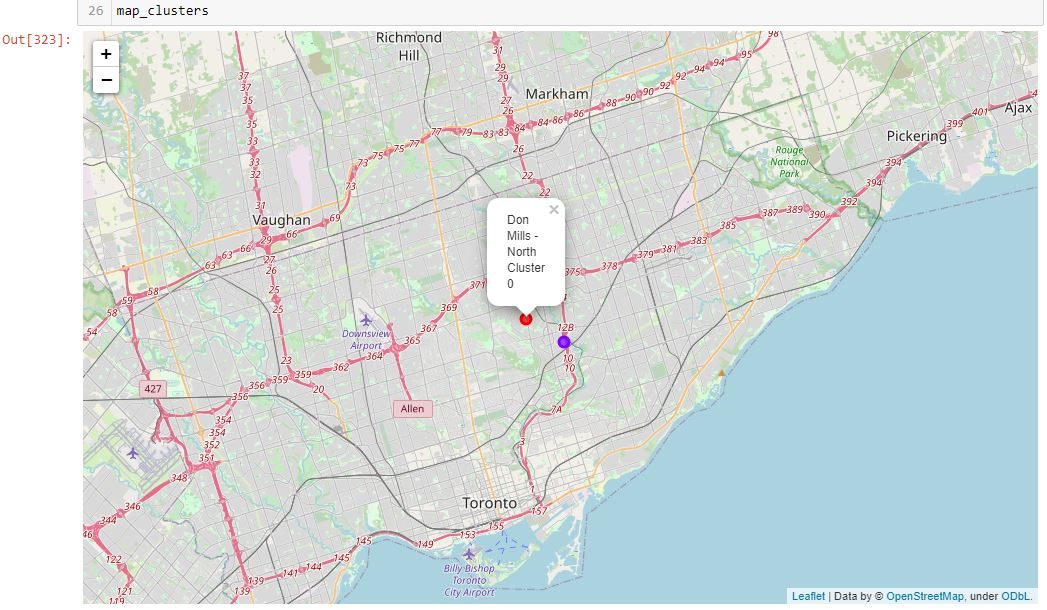

### Examine Clusters

In [325]:
# Define display function
def display_cluster(n):
    cluster_elts = temp_nh_merged.loc[temp_nh_merged['Cluster Labels'] == n, 
                                      temp_nh_merged.columns[[2] + list(range(5, temp_nh_merged.shape[1]))]]
    cluster_elts.reset_index(drop=True, inplace=True)
    print ('Cluster {} has {} Neighbourhood(s)\n'.format(n, cluster_elts.shape[0]))
    return cluster_elts
# Start with cluster number = 0
num_cluster = 0

In [ ]:
##### Cluster 0

In [326]:
display_cluster(num_cluster)

Cluster 0 has 1 Neighbourhood(s)



,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Don Mills - North,0,Coffee Shop,Gas Station,Fast Food Restaurant,Athletics & Sports,Soccer Field,Diner,Sandwich Place,Bank,Restaurant,Park


##### Cluster 1

In [327]:
num_cluster = num_cluster + 1
display_cluster(num_cluster)

Cluster 1 has 1 Neighbourhood(s)



,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Don Mills - South, Flemingdon Park",1,Restaurant,Coffee Shop,Gym,Salon / Barbershop,Middle Eastern Restaurant,Park,Pizza Place,Shopping Mall,Beer Store,Gym / Fitness Center


### END of Task 3

### Conclusion
<p>I tried to take this assignment a little more into a realistic use case for the clustering and mapping by allowing the user to input a string for the neighborhood, and a distance (in meters) to get venues.  I thought that was more like it might actually be used.</p>

